In [1]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
wine = fetch_ucirepo(id=109) 
  
# data (as pandas dataframes) 
X = wine.data.features 
y = wine.data.targets 
  
# metadata 
print(wine.metadata) 
  
# variable information 
print(wine.variables) 


{'uci_id': 109, 'name': 'Wine', 'repository_url': 'https://archive.ics.uci.edu/dataset/109/wine', 'data_url': 'https://archive.ics.uci.edu/static/public/109/data.csv', 'abstract': 'Using chemical analysis to determine the origin of wines', 'area': 'Physics and Chemistry', 'tasks': ['Classification'], 'characteristics': ['Tabular'], 'num_instances': 178, 'num_features': 13, 'feature_types': ['Integer', 'Real'], 'demographics': [], 'target_col': ['class'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1992, 'last_updated': 'Mon Aug 28 2023', 'dataset_doi': '10.24432/C5PC7J', 'creators': ['Stefan Aeberhard', 'M. Forina'], 'intro_paper': {'ID': 246, 'type': 'NATIVE', 'title': 'Comparative analysis of statistical pattern recognition methods in high dimensional settings', 'authors': 'S. Aeberhard, D. Coomans, O. Vel', 'venue': 'Pattern Recognition', 'year': 1994, 'journal': None, 'DOI': '10.1016/0031-3203(94)90145-7', 'URL': 'https:

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm

from sklearn.neighbors import KNeighborsClassifier

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler, TargetEncoder

from sklearn.impute import KNNImputer

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.compose import TransformedTargetRegressor

from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, confusion_matrix

from test_class import PRKNeighborsClassifier
from tqdm import tqdm

import seaborn as sns



In [3]:
X.head()

,Alcohol,Malicacid,Ash,Alcalinity_of_ash,Magnesium,Total_phenols,Flavanoids,Nonflavanoid_phenols,Proanthocyanins,Color_intensity,Hue,0D280_0D315_of_diluted_wines,Proline
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [4]:
X.isna().sum()

Alcohol                         0
Malicacid                       0
Ash                             0
Alcalinity_of_ash               0
Magnesium                       0
Total_phenols                   0
Flavanoids                      0
Nonflavanoid_phenols            0
Proanthocyanins                 0
Color_intensity                 0
Hue                             0
0D280_0D315_of_diluted_wines    0
Proline                         0
dtype: int64

In [5]:
y.isna().sum()

class    0
dtype: int64

(array([59.,  0.,  0.,  0.,  0., 71.,  0.,  0.,  0., 48.]),
 array([1. , 1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4, 2.6, 2.8, 3. ]),
 <BarContainer object of 10 artists>)

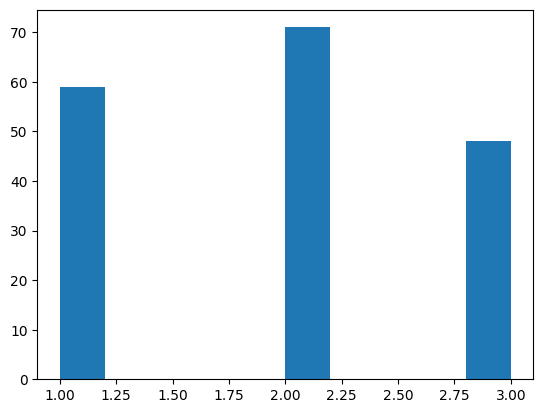

In [6]:
# inspect the class imbalance of y

plt.hist(y)

In the paper, they test model accuracy by  reporting crossvalidation scores. They do not mention what preprocessing they completed, so I am going to assume they did none. I will replicate their cross-validation process as written, and then explore how pre-processing infuences the scores

In [7]:
# use 10 fold cross validation and return f1 and accuracy for each k

k_values = [5, 15, 30, 45]

# TODO: add roc_auc
scoring = ('f1_macro', 'accuracy')
y=np.ravel(y)

standard_scores = []

for k in k_values:
    
    pr_knn_standard = PRKNeighborsClassifier(
        pr_version='standard',
        base_knn_params={"n_neighbors": k}).fit(X.values, y)
    
    pr_knn_weighted = PRKNeighborsClassifier(
        pr_version='weighted',
        base_knn_params={"n_neighbors": k}).fit(X.values,y)
    
    pr_knn_enhanced = PRKNeighborsClassifier(
        pr_version='enhanced',
        base_knn_params={"n_neighbors": k}).fit(X.values,y)
    
    standard_scores.append(
            cross_validate(
            estimator=pr_knn_standard,
            X=X.values,
            y=y,
            scoring=scoring,
            cv=10
        )
    )
    


(0.0, 1.0)

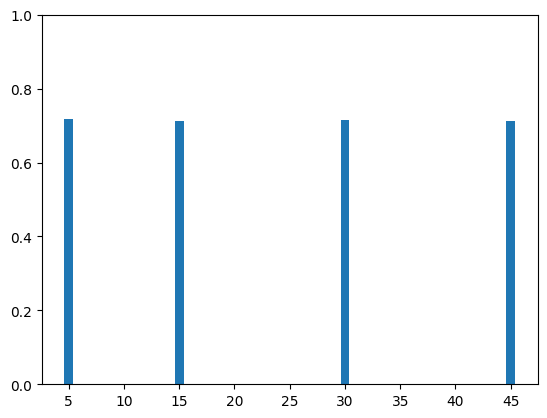

In [8]:
standard_f1_scores = np.array([d['test_f1_macro'] for d in standard_scores])
fig, ax = plt.subplots()

ax.bar(k_values, np.average(standard_f1_scores, axis=1))
ax.set_ylim(0,1)

given the lack of scaling, it makes me think that may explain why the model f1 score is not changing with k, so i will repeat with some scaling


In [9]:
# use 10 fold cross validation and return f1 and accuracy for each k with 
# feature scaling

k_values = [5, 15, 30, 45]

# TODO: add roc_auc
scoring = ('f1_macro', 'accuracy')
y=np.ravel(y)

mnmx_scaler = MinMaxScaler()
X = mnmx_scaler.fit_transform(X)

standard_scores = []
weighted_scores = []
enhanced_scores = []

for k in k_values:
    
    pr_knn_standard = PRKNeighborsClassifier(
        pr_version='standard',
        base_knn_params={"n_neighbors": k}
        ).fit(X, y)
    
    pr_knn_weighted = PRKNeighborsClassifier(
        pr_version='weighted',
        base_knn_params={"n_neighbors": k}
        ).fit(X,y)
    
    pr_knn_enhanced = PRKNeighborsClassifier(
        pr_version='enhanced',
        base_knn_params={"n_neighbors": k}
        ).fit(X,y)

    standard_scores.append(
            cross_validate(
            estimator=pr_knn_standard,
            X=X,
            y=y,
            scoring=scoring,
            cv=10
            )
        )
    
    weighted_scores.append(
            cross_validate(
            estimator=pr_knn_weighted,
            X=X,
            y=y,
            scoring=scoring,
            cv=10
            )
    )

    enhanced_scores.append(
            cross_validate(
            estimator=pr_knn_enhanced,
            X=X,
            y=y,
            scoring=scoring,
            cv=10
            )
        )

In [10]:
from figure_helpers import generate_score_plot

<Axes: title={'center': 'Wine'}, xlabel='K', ylabel='F1'>

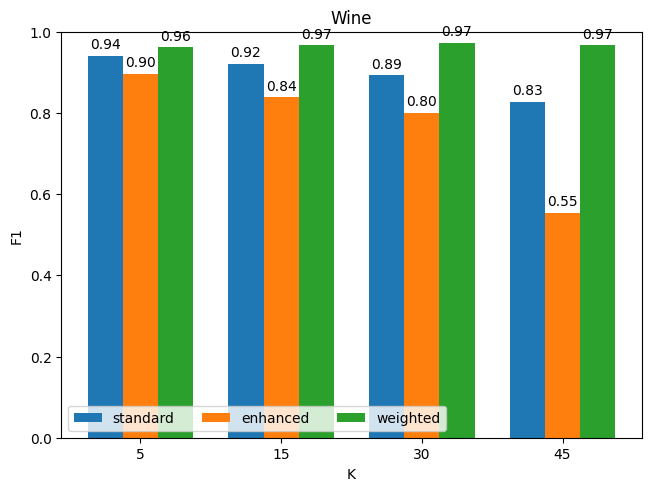

In [11]:
scores = {}

scores["standard"] = np.array([d['test_f1_macro'] for d in standard_scores])
scores["enhanced"] = np.array([d['test_f1_macro'] for d in enhanced_scores])
scores["weighted"] = np.array([d['test_f1_macro'] for d in weighted_scores])

# plotting the averages
x = np.arange(len(k_values))
width = 0.25
multiplier = 0



fig, ax = plt.subplots(layout='constrained')

generate_score_plot(
    scores=scores,
    metric= "F1",
    k_values=k_values,
    dataset_name="Wine",
    ax=ax
)

# for model, score in scores.items():
#     offset = width * multiplier
#     rects = ax.bar(x + offset,np.average(score, axis=1), width, label=model)
#     ax.bar_label(rects, padding=3,fmt="%.2f")
#     multiplier +=1

# ax.set_title("Wine")
# ax.legend(loc='lower left', ncols=3)
# ax.set_ylim(0,1)
# ax.set_xticks(x + width, k_values)
# ax.set_xlabel("K")
# ax.set_ylabel("F1")
# plt.show()